# Install Dependencies

In [ ]:
!pip install pillow           # For PIL (Python Imaging Library)
!pip install numpy            # For numpy (though usually included with Jupyter)
!pip install scikit-learn     # For sklearn
!pip install tensorflow       # For keras (now part of TensorFlow)
!pip install scipy            # For scipy.ndimage
!pip install matplotlib       # For matplotlib.pyplot

# Run this cell if you are on linux

In [ ]:
sudo apt-get install python3-tk

# Importing libraries

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from scipy.ndimage import center_of_mass, shift
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt

# To read images/ prepare feature vector and convert labels to one hot encoded vectors

In [9]:
def one_hot_encode_labels(labels):
    """
    Convert labels into one-hot encoded vectors.
    
    Parameters:
        labels: List or 1D array of integers (0-9).

    Returns:
        one_hot_labels: 2D NumPy array of shape (n_samples, 10).
    """
    n_samples = len(labels)
    one_hot_labels = np.zeros((n_samples, 10))
    one_hot_labels[np.arange(n_samples), labels] = 1
    return one_hot_labels


def extract_features(image):
    """
    Extract features from a 28x28 image by flattening it into a 1D array.
    
    Parameters:
        image: 2D NumPy array (28x28) - grayscale image.

    Returns:
        features: 1D NumPy array (784) - flattened image.
    """
    return image.flatten()


def preprocess_dataset(x,y):
    """
    Process images and labels for a digit recognition model.

    Parameters:
        Images and their classification

    Returns:
        features_array: 2D NumPy array (n_samples, 784) - flattened image features.
        one_hot_labels: 2D NumPy array (n_samples, 10) - one-hot encoded labels.
    """
    x = x / 255.0  # Normalize

    features_list = []
    labels_list = []

    for image, label in zip(x, y):
        # Center by center of mass
        cy, cx = center_of_mass(image)
        dy, dx = 13.5 - cy, 13.5 - cx
        centered_image = shift(image, shift=(dy, dx), order=1, mode='constant', cval=0.0)
        
        # Extract DCT features
        features = extract_features(centered_image)

        features_list.append(features)
        labels_list.append(label)

    features_array = np.array(features_list)
    one_hot_labels = one_hot_encode_labels(labels_list)

    return features_array, one_hot_labels


(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
x_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((Y_train, Y_test))
features_array, one_hot_labels = preprocess_dataset(x_full, y_full)

features_train = features_array[:60000,:]
features_val = features_array[60000:,:]
one_hot_labels_train = one_hot_labels[:60000,:]
one_hot_labels_val = one_hot_labels[60000:,:]

print("Feature Array Shape:", features_array.shape)  # Should be (n_samples, 784)
print("One-Hot Labels Shape:", one_hot_labels.shape)  # Should be (n_samples, 10)


Feature Array Shape: (70000, 784)
One-Hot Labels Shape: (70000, 10)


# ReLu and it's derivative

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Function

In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function

In [6]:
def cross_entropy_loss(y_true, y_pred):
    # Categorical cross-entropy loss with a small value epsilon to avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Adam optimizer

In [7]:
def adam_update(param, grad, m, v, t, lr):
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * np.square(grad)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
    return param, m, v

# Training the NN

In [17]:
# Initialize neural network parameters
input_size = 784
hidden_layer_1_size = 828
hidden_layer_2_size = 512
output_size = 10
learning_rate = 0.0015
epochs = 8
batch_size = 64

# Random seed for reproducibility
np.random.seed(42)

# Initialize weights and biases
w1 = np.random.randn(input_size, hidden_layer_1_size) * 0.01
b1 = np.zeros((1, hidden_layer_1_size))

w2 = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) * 0.01
b2 = np.zeros((1, hidden_layer_2_size))

w3 = np.random.randn(hidden_layer_2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))


# Adam optimizer state variables (momentum, velocity)
m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_w3, v_w3 = np.zeros_like(w3), np.zeros_like(w3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)

beta1, beta2 = 0.9, 0.999  # Adam parameters
epsilon = 1e-8  # For numerical stability

# Learning rate decay
lr_scheduler = lambda epoch: learning_rate * max(0.90 ** epoch, 1e-6)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(features_train, one_hot_labels_train, test_size=0.2, random_state=42)

loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = int(x_train.shape[0] / batch_size)
    
    for batch in range(num_batches):
        # Get the current batch
        start = batch * batch_size
        end = start + batch_size
        X_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Forward pass
        z1 = np.dot(X_batch, w1) + b1
        a1 = relu(z1)
        
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        
        z3 = np.dot(a2, w3) + b3
        
        y_pred = softmax(z3)

        # Calculate loss
        loss = cross_entropy_loss(y_batch, y_pred)
        epoch_loss += loss
        
        # Calculate accuracy
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        epoch_accuracy += accuracy

        # Backpropagation
        # Output layer gradients
        dz3 = y_pred - y_batch  # Gradient of loss w.r.t output layer
        dw3 = np.dot(a2.T, dz3) / batch_size
        db3 = np.sum(dz3, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 2 gradients
        dz2 = np.dot(dz3, w3.T) * relu_derivative(a2)
        dw2 = np.dot(a1.T, dz2) / batch_size
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 1 gradients
        dz1 = np.dot(dz2, w2.T) * relu_derivative(a1)
        dw1 = np.dot(X_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

        w1, m_w1, v_w1 = adam_update(w1, dw1, m_w1, v_w1, epoch+1, lr_scheduler(epoch))
        b1, m_b1, v_b1 = adam_update(b1, db1, m_b1, v_b1, epoch+1, lr_scheduler(epoch))

        w2, m_w2, v_w2 = adam_update(w2, dw2, m_w2, v_w2, epoch+1, lr_scheduler(epoch))
        b2, m_b2, v_b2 = adam_update(b2, db2, m_b2, v_b2, epoch+1, lr_scheduler(epoch))

        w3, m_w3, v_w3 = adam_update(w3, dw3, m_w3, v_w3, epoch+1, lr_scheduler(epoch))
        b3, m_b3, v_b3 = adam_update(b3, db3, m_b3, v_b3, epoch+1, lr_scheduler(epoch))

    # Epoch metrics
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss/num_batches:.4f}, Accuracy: {epoch_accuracy/num_batches:.4f}")
    
    # Validation loss and accuracy after every epoch
    z1_val = np.dot(x_test, w1) + b1
    a1_val = relu(z1_val)
    z2_val = np.dot(a1_val, w2) + b2
    a2_val = relu(z2_val)
    z3_val = np.dot(a2_val, w3) + b3
    y_pred_val = softmax(z3_val)
    
    val_loss = cross_entropy_loss(y_test, y_pred_val)
    val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_test, axis=1))

    loss_history.append(loss)
    val_loss_history.append(val_loss)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Learning rate: {lr_scheduler(epoch)}","\n")

Epoch 1/8 - Loss: 0.2080, Accuracy: 0.9350
Validation Loss: 0.1095, Validation Accuracy: 0.9657
Learning rate: 0.0015 

Epoch 2/8 - Loss: 0.0716, Accuracy: 0.9785
Validation Loss: 0.0767, Validation Accuracy: 0.9777
Learning rate: 0.00135 

Epoch 3/8 - Loss: 0.0477, Accuracy: 0.9860
Validation Loss: 0.0686, Validation Accuracy: 0.9803
Learning rate: 0.0012150000000000002 

Epoch 4/8 - Loss: 0.0346, Accuracy: 0.9901
Validation Loss: 0.0655, Validation Accuracy: 0.9814
Learning rate: 0.0010935 

Epoch 5/8 - Loss: 0.0259, Accuracy: 0.9932
Validation Loss: 0.0637, Validation Accuracy: 0.9822
Learning rate: 0.00098415 

Epoch 6/8 - Loss: 0.0198, Accuracy: 0.9954
Validation Loss: 0.0628, Validation Accuracy: 0.9833
Learning rate: 0.0008857350000000001 

Epoch 7/8 - Loss: 0.0154, Accuracy: 0.9968
Validation Loss: 0.0624, Validation Accuracy: 0.9843
Learning rate: 0.0007971615000000001 

Epoch 8/8 - Loss: 0.0121, Accuracy: 0.9977
Validation Loss: 0.0627, Validation Accuracy: 0.9848
Learning ra

# Performance metrics

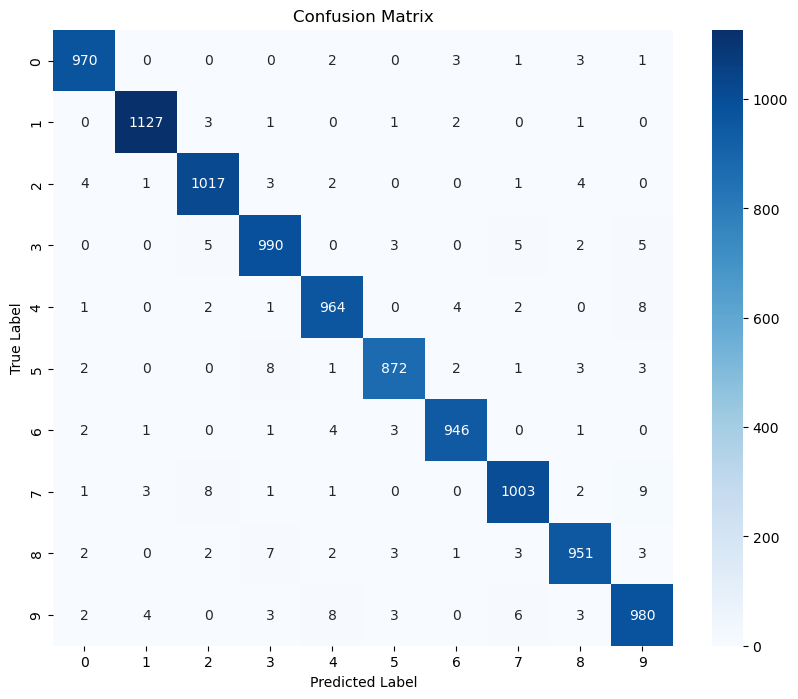

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



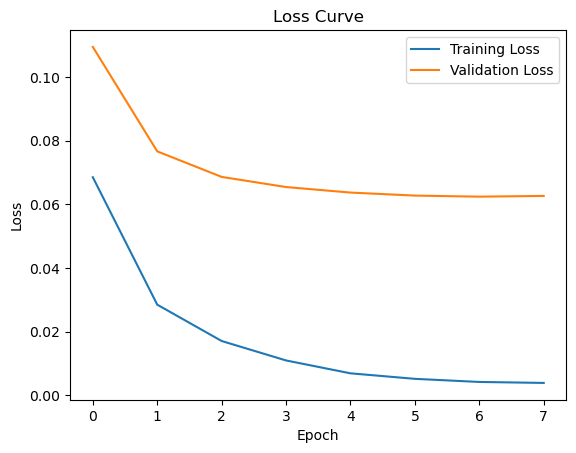

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Predict on validation/test set
z1_val = np.dot(features_val, w1) + b1
a1_val = np.maximum(0, z1_val)
z2_val = np.dot(a1_val, w2) + b2
a2_val = np.maximum(0, z2_val)
z3_val = np.dot(a2_val, w3) + b3
y_pred_val = softmax(z3_val)
y_pred_labels = np.argmax(y_pred_val, axis=1)
y_true_labels = np.argmax(one_hot_labels_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Loss Curve (if you stored epoch_loss values)
plt.plot(loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Attach image for prediction

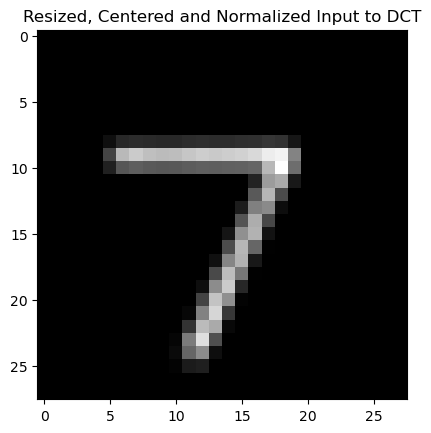

Predicted Digit: 7


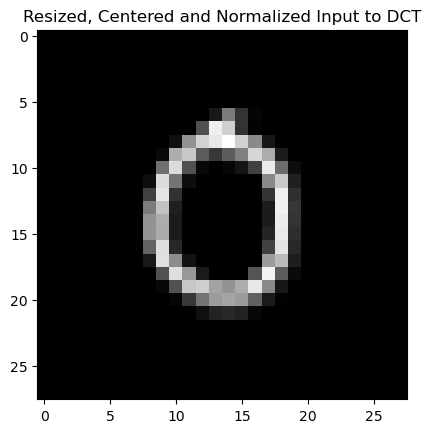

Predicted Digit: 0


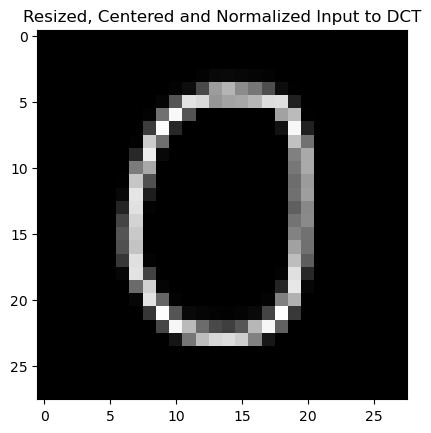

Predicted Digit: 0


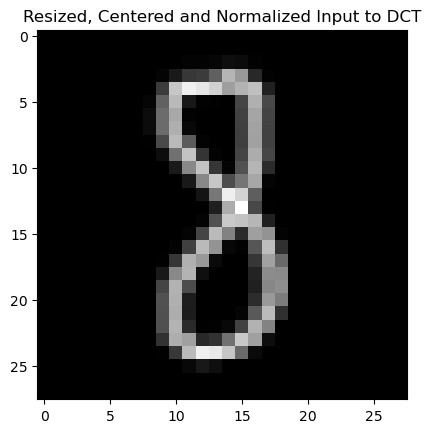

Predicted Digit: 8


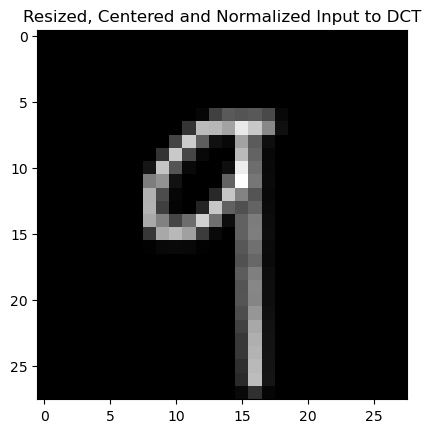

Predicted Digit: 9


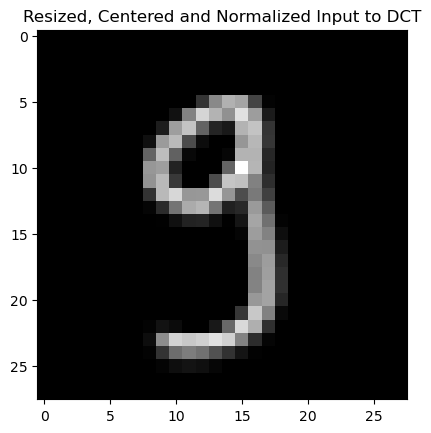

Predicted Digit: 9


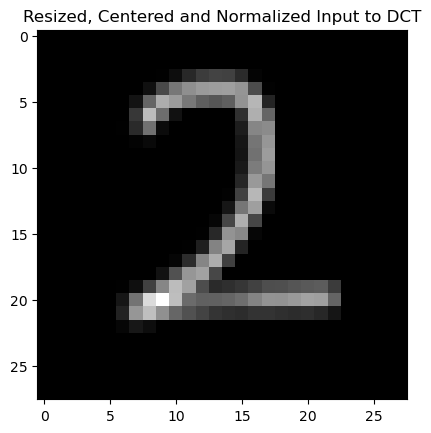

Predicted Digit: 2


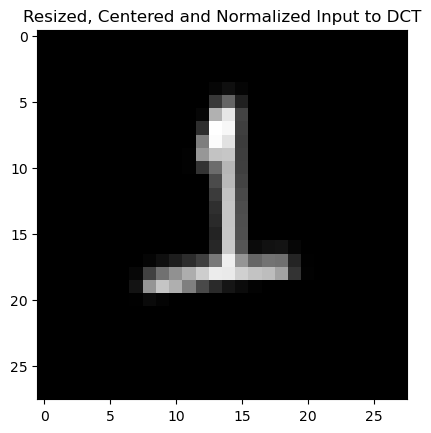

Predicted Digit: 1


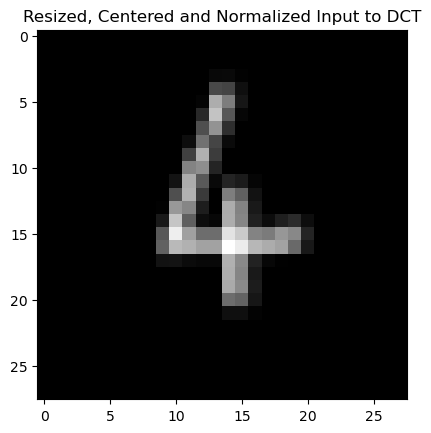

Predicted Digit: 4


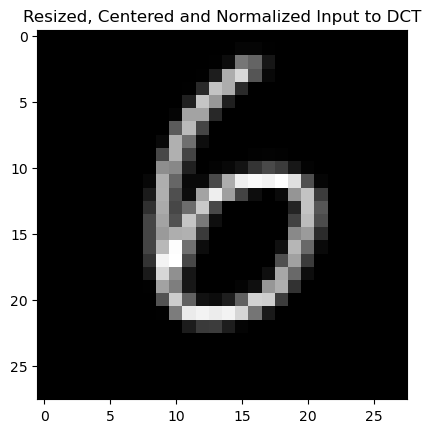

Predicted Digit: 6


In [20]:
# --- Tkinter canvas setup ---
canvas_width = 500
canvas_height = 500
white = (255, 255, 255)

root = tk.Tk()
root.title("Draw a Digit")
canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg='black')
canvas.pack()

image1 = Image.new("L", (canvas_width, canvas_height), color=0)
draw = ImageDraw.Draw(image1)

def paint(event):
    x1, y1 = (event.x - 7), (event.y - 7)
    x2, y2 = (event.x + 7), (event.y + 7)
    canvas.create_oval(x1, y1, x2, y2, fill="white", width=0)
    draw.ellipse([x1, y1, x2, y2], fill=255)

canvas.bind("<B1-Motion>", paint)

# --- Helper Functions ---
def preprocess_and_predict(img):
    img = img.resize((28, 28))
    img = np.array(img) / 255.0

    cy, cx = center_of_mass(img)
    dy, dx = 13.5 - cy, 13.5 - cx
    centered_img = shift(img, shift=(dy, dx), order=1, mode='constant', cval=0.0)
    
    plt.imshow(centered_img, cmap='gray')
    plt.title("Resized, Centered and Normalized Input to DCT")
    plt.show()

    features = extract_features(centered_img)
    features = features.reshape(1, -1)


    # Forward pass
    z1 = np.dot(features, w1) + b1
    a1 = np.maximum(0, z1)
    z2 = np.dot(a1, w2) + b2
    a2 = np.maximum(0, z2)
    z3 = np.dot(a2, w3) + b3
    y_pred = softmax(z3)
    prediction = np.argmax(y_pred)
    
    print(f"Predicted Digit: {prediction}")

def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, canvas_width, canvas_height], fill=0)

# --- Buttons ---
tk.Button(root, text="Predict", command=lambda: preprocess_and_predict(image1.copy())).pack()
tk.Button(root, text="Clear", command=clear_canvas).pack()

root.mainloop()